# Section 3. Ring series verified by exhaustive search

In **Section 3** we derive several symbolic expressions for the generating functions of digraphs.
They can be checked empircially for small digraphs.

In this notebook, we are going to compare the counting sequences obtained from generating functions and from exhaustive search.

`ring_series` is a part of a handy `sympy` library. The default `sympy` implementation for multivariate power series is slow and non-stable, and a faster reliable implementation is available. Up to date, `ring_series` is not yet fully integrated as a default engine into `sympy`, and for this reason we import it separately.

The easiest way to represent power series is to use rational numbers (and NOT floating point high-precision numbers which can be another possibility). It might seem at first glance that using floating-point arithmtics could save some space and speed up the computation, but in reality, the inclusions-exclusions are so heavy that in order to capture the final answer, we inevitably need to increase the floating point (fixed) precision. This results in a substantial slow-down in computations (`ring_series` uses a quadratic algorithm to multiply two polynomials, but even though there are other, univariate, libraries, that use faster Karatsuba algorithm, it is still very slow).
On the other hand, rational numbers are "adaptive" from the viewpoint of precision arithmetics, so it is advantageous both from the memory and time viewpoint to use the field $\mathbb Q$.

`ring_series` perform relatively well for moderate series sizes (up to a million if the coefficients are integers), but for more sophisticated high-performance computations we will need `FLINT`, which is used in other notebooks.

In [1]:
# Specify the path for the modules
import sys
import os.path as osp
sys.path.append(osp.join(osp.abspath(''), '..', 'lib'))

In [2]:
import sympy as sp
from sympy.polys import ring, QQ, RR
from sympy.polys.ring_series import rs_subs

R, z, w = ring('z,w', QQ)

In [4]:
from sympy.polys import ring, QQ, RR
from sympy.polys.ring_series import rs_mul, rs_subs
from sympy.polys.ring_series import rs_exp, rs_pow, rs_log
from sympy.polys.ring_series import rs_series_inversion

In [5]:
import rs_utils

We provide a custom module `gf_families` with pre-defined generating functions of different digraph families

In [6]:
import gf_families

## Directed acyclic graphs

The two Graphic GF describe simple-DAGs and multi-DAGs:

$$\mathrm{DAG}_{\text{simple}}(z, w) = \dfrac{1}{\sum_{n \geq 0} (1 + w)^{-\binom{n}{2}} \frac{(-z)^n}{n!}}$$

In [7]:
gf_families.gf_dags(z, w, 4, 4)

-2/3*z**3*w**3 + 1/2*z**3*w + 1/6*z**3 + 1/2*z**2*w**3 - 1/2*z**2*w**2 + 1/2*z**2*w + 1/2*z**2 + z + 1

$$
    \mathrm{DAG}_{\text{multi}}(z, w) = \dfrac{1}{\sum_{n \geq 0} e^{-w n^2/2} \frac{(-z)^n}{n!}}
$$

In [8]:
gf_families.gf_mdags(z, w, 4, 4)

-47/96*z**3*w**3 - 5/16*z**3*w**2 + 1/4*z**3*w + 1/6*z**3 + 1/2*z**2*w**3 - 1/2*z**2*w**2 + 1/2*z**2 - 1/48*z*w**3 + 1/8*z*w**2 - 1/2*z*w + z + 1

There are 152 DAGs with 4 vertices and 3 edges:

In [9]:
gf_families.count_DAGs(4,3)

152

In [10]:
print("The number of DAGs with given number of nodes and edges")
for n in range(5):
    print("Counting sequence for n =", n)
    print([gf_families.count_DAGs(n,m) for m in range(n*(n-1)//2+1)])

The number of DAGs with given number of nodes and edges
Counting sequence for n = 0
[1]
Counting sequence for n = 1
[1]
Counting sequence for n = 2
[1, 2]
Counting sequence for n = 3
[1, 6, 12, 6]
Counting sequence for n = 4
[1, 12, 60, 152, 186, 108, 24]


* When n=0, there is a unique DAG with no vertices
* When n=1, there is a unique DAG with one vertex
* When n=2, and m=0, there is a unique DAG on isolated vertices
* When n=2, and m=1, there are two labelled DAGs
* (n,m) = (3, 1) there are 6 possibilities to put one directed edge
* (n,m) = (3, 2) two edges never form a cycle except they link identical vertices. 6 possibilities for the first edge. The second edge should not be opposite or identical, leaving 4 possibilities. The order of the edges is not fixed, so division by 2 is necessary.
* (n,m) = (3, 3) the only possibility is a triangle, but the orientations are chosen in such a way that no cycles appear. Among 8 orientations 2 contain cycles, leaving only 6 options.
* (n,m) = (4,3)
    * three outgoing arrows to a vertex ($4\cdot 8 = 32$ possibilities)
    * a path of three edges with any orientations ($4! \cdot 2^3 = 96$)
    * triangle and an isolated vertex (24)
    * Total: 24 + 96 + 32 = 152

# Exhaustive search

We implement exhaustive search using `NetworkX` which is a Python library for dealing with graphs, digraphs and multigraphs. We use it inside another custom module `nx_utils.py` for additional operations with digraphs and a module for exhaustive counting of digraph families `exhaustive.py`

In [12]:
import exhaustive

Let us enumerate all directed graphs with given number of vertices and edges and count how many of them are directed acyclic

In [13]:
## There are exactly 152 simple DAGs with 4 vertices and 3 edges

print(exhaustive.count_DAGs(4,3))
print(gf_families.count_DAGs(4,3))

152
152


**We can make an explicit drawing of these 152 digraphs**

In [15]:
import networkx as nx
import itertools
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib

Fontconfig warning: ignoring UTF-8: not a valid region tag


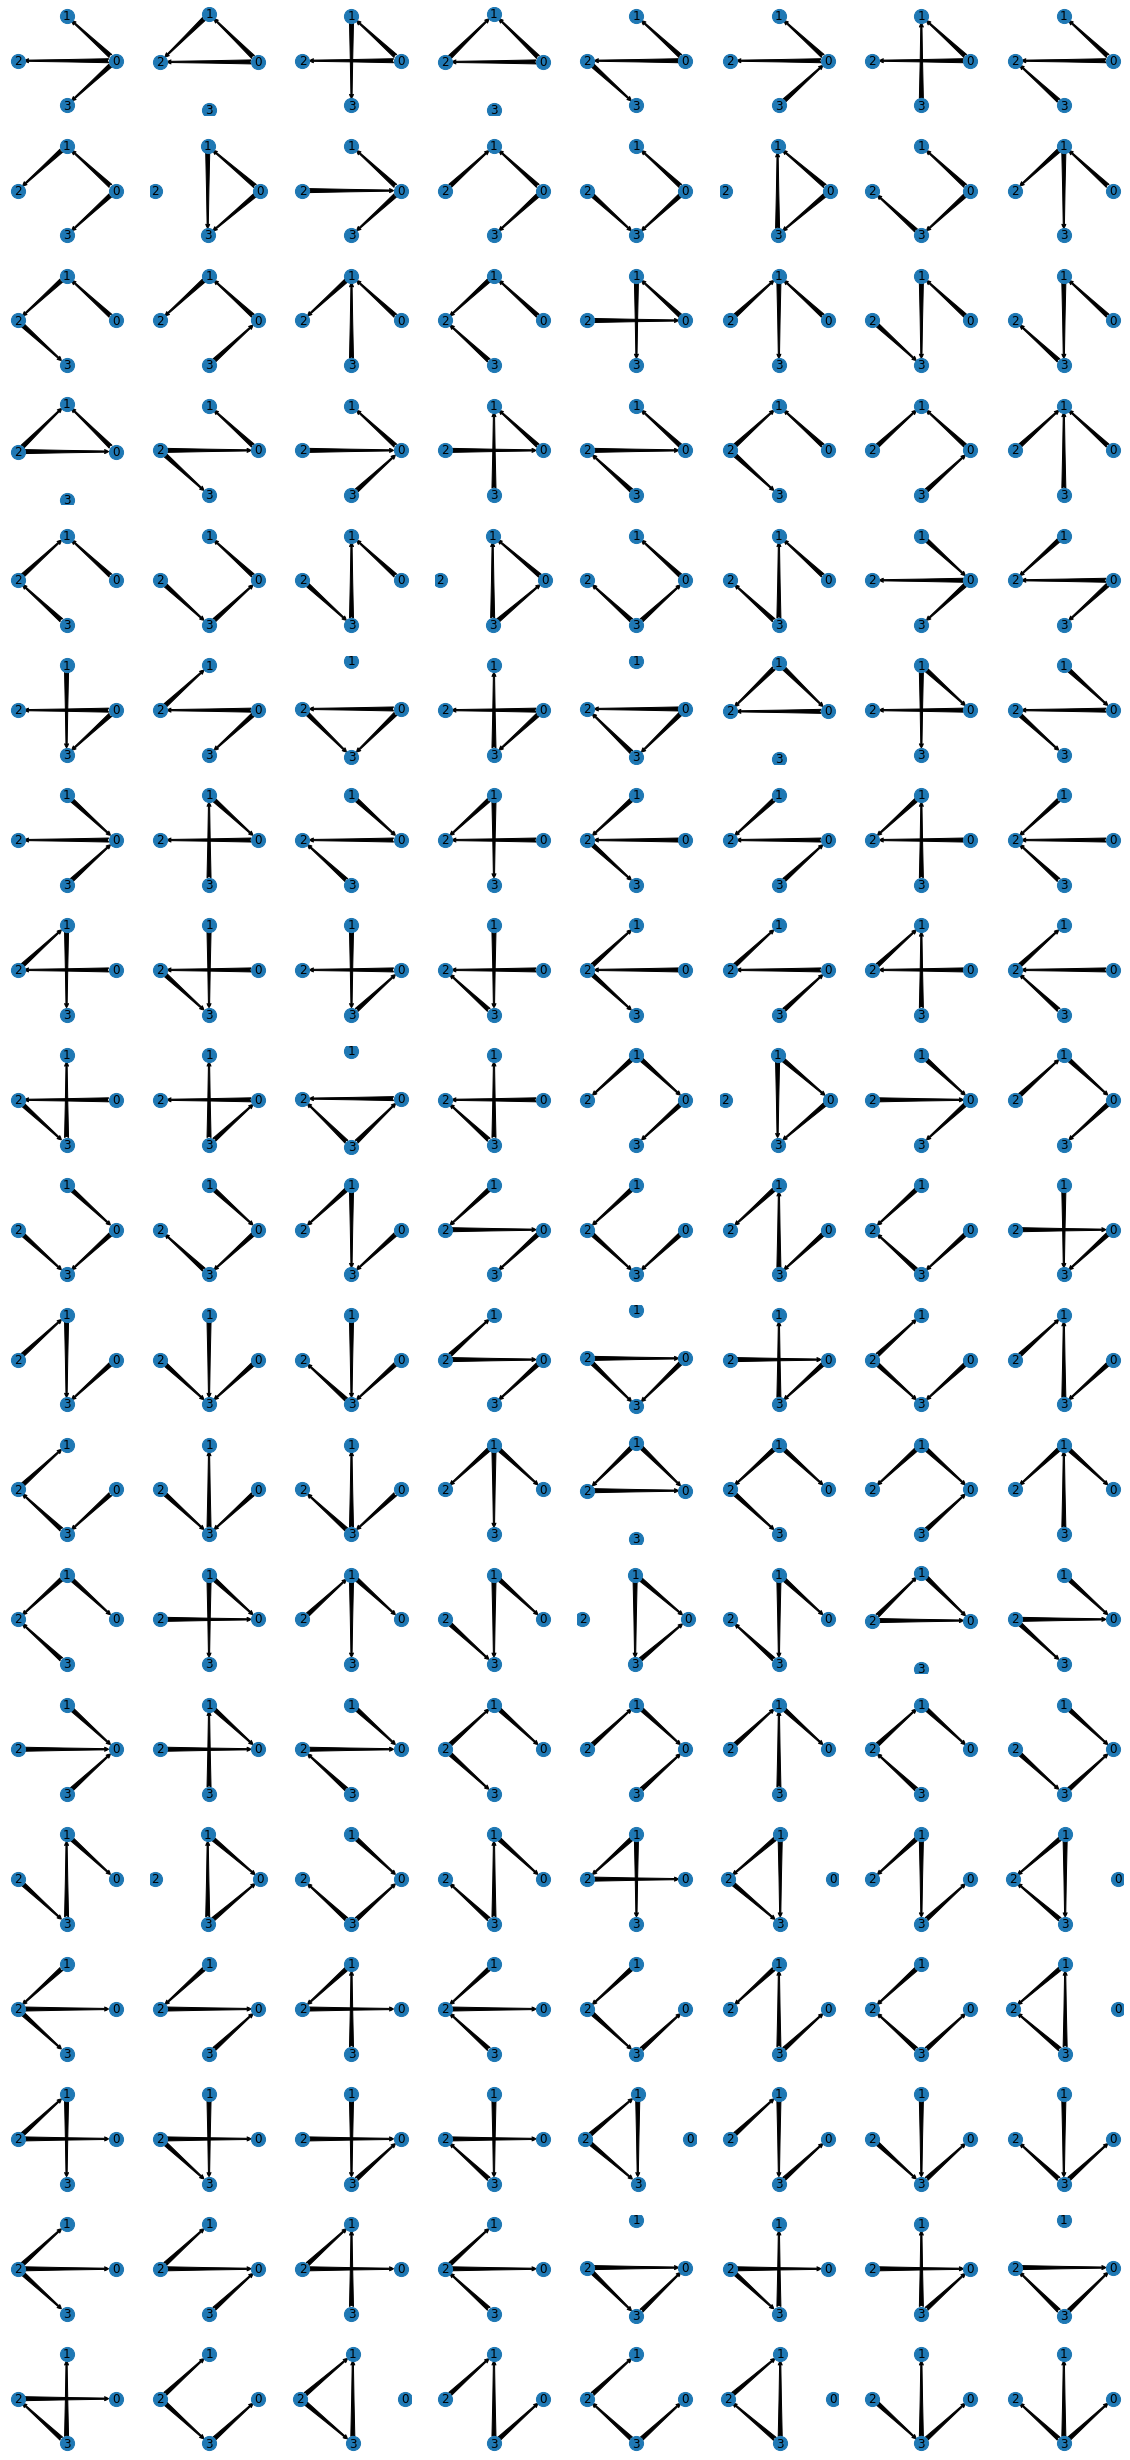

In [16]:
n = 4
m = 3

vertices = range(n)
edges = [
    (p, q)
    for p in range(n)
    for q in chain(range(p), range(p + 1, n)) # skip p
]

fig, axs = plt.subplots(19, 8, figsize=(20,45))    # 19 * 8 = 152
plt.axis("on")

graph_n = 0
xcoord = 0
ycoord = 0

for E in itertools.combinations(edges, m):
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    for e in E:
        G.add_edge(e[0], e[1])
    if nx.is_directed_acyclic_graph(G):
        nx.draw_circular(
            G,
            ax = axs[ycoord, xcoord],
            arrowstyle="fancy",
            node_size=200,
            with_labels=True)
        ax = axs[ycoord, xcoord]
        graph_n += 1
        xcoord = graph_n % 8
        ycoord = (graph_n - xcoord) // 8

**The counting sequence for simple DAGs with n=4**

In [17]:
[
    exhaustive.count_DAGs(4, m) for m in range(7)
]

[1, 12, 60, 152, 186, 108, 24]

In [18]:
[
    gf_families.count_DAGs(4, m) for m in range(7)
]

[1, 12, 60, 152, 186, 108, 24]

**The counting sequence for simple DAGs with n=5**

In [19]:
[
    exhaustive.count_DAGs(5, m) for m in range(11)
]

[1, 20, 180, 940, 3050, 6180, 7960, 6540, 3330, 960, 120]

In [20]:
[
    gf_families.count_DAGs(5, m) for m in range(11)
]

[1, 20, 180, 940, 3050, 6180, 7960, 6540, 3330, 960, 120]

In [21]:
for n in range(6):
    for m in range(11):
        assert(gf_families.count_DAGs(n,m)==exhaustive.count_DAGs(n, m))

# Complete brute force testing

Here is a copy of the code from the testing script that checks the equivalence of the counting sequences derived from generating functions and from exhaustive enumeration.

In [22]:
for n in range(1,5):
    for m in range(10):
        
        ## Strongly connected components in three models
        assert(
            gf_families.count_scc(n, m, multi=True)
            ==
            exhaustive.count_scc(n, m, multi=True))
        assert(
            gf_families.count_scc(n, m, multi=False, d2=False)
            ==
            exhaustive.count_scc(n, m, multi=False, d2=False))
        assert(
            gf_families.count_scc(n, m, multi=False, d2=True)
            ==
            exhaustive.count_scc(n, m, multi=False, d2=True))

        ## Digraph families with one bicycle
        assert(
            gf_families.count_with_one_bicycle(n, m, multi=True)
            ==
            exhaustive.count_with_one_bicycle(n, m, multi=True))
        assert(
            gf_families.count_with_one_bicycle(n, m, multi=False, d2=False)
            ==
            exhaustive.count_with_one_bicycle(n, m, multi=False, d2=False))
        assert(
            gf_families.count_with_one_bicycle(n, m, multi=False, d2=True)
            ==
            exhaustive.count_with_one_bicycle(n, m, multi=False, d2=True))  

        ## Directed acyclic graphs
        assert(
            gf_families.count_DAGs(n, m)
            ==
            exhaustive.count_DAGs(n, m))
        assert(
            gf_families.count_DAGs(n, m, multi=True)
            ==
            exhaustive.count_DAGs(n, m, multi=True))

        ## Elementary digraphs
        assert(
            gf_families.count_elem(n, m, multi=True)
            ==
            exhaustive.count_elem(n, m, multi=True))
        assert(
            gf_families.count_elem(n, m, multi=False, d2=True)
            ==
            exhaustive.count_elem(n, m, multi=False, d2=True))
        assert(
            gf_families.count_elem(n, m, multi=False, d2=False)
            ==
            exhaustive.count_elem(n, m, multi=False, d2=False))

# Cubic strongly connected digraphs

We can numerically check the formula for \\( s_r \\) in the paper:
\\[
    s_r = [z^{2r} w^{3r}] (1 - wz)^{3r-1} \mathrm{Strong}(z, w)
\\]

We expect (from Wright's recurrences) and from the paper "the birth of the giant component" that
\\[
    (s_r)_{r \geqslant 1} = \left(
        \dfrac{1}{2}, \dfrac{17}{8}, \dfrac{275}{12},
        \dfrac{26141}{64}, \dfrac{1630711}{160}, \ldots
    \right)
\\]

In [33]:
for r in [1,2,3,4,5]:
    print((
        gf_families.gf_strongly_connected(z, w, 2*r+1, 3*r+1, multi=True) * (1 - w*z)**(3*r - 1)
    ).coeff(z**(2*r) * w**(3*r)))

1/2
17/8
275/12
26141/64
1630711/160


Thank you for reading.